# Sliding Windows / Heat Map Test

## Load Saved SVC

In [1]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
from lesson_functions import *

svc = None
X_train_scaler = None

with open('svm-yuv-16x2x11.p', 'rb') as f:
    data = pickle.load(f)
    print(data)
    svc = data['svm']
    X_scaler = data['scaler']
    params = data['params']

color_space = params['color_space']
color_space_code = eval('cv2.COLOR_RGB2' + params['color_space'])
print('SVM loaded: svc')
print('Scaler loaded: X_train_scaler')
print('Color Space: cv2.COLOR_RGB2' + color_space)

{'params': {'color_space': 'YUV', 'hist_feat': True, 'spatial_size': (32, 32), 'hog_feat': True, 'kernel': 'linear', 'spatial_feat': True, 'hist_bins': 32, 'pix_per_cell': 16, 'cell_per_block': 2, 'C': 1, 'hog_channel': 'ALL', 'orient': 11}, 'scaler': StandardScaler(copy=True, with_mean=True, with_std=True), 'svm': LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)}
SVM loaded: svc
Scaler loaded: X_train_scaler
Color Space: cv2.COLOR_RGB2YUV


In [2]:
def get_window_features(window_img_cs):
    if window_img_cs.shape[0] != 64 or window_img_cs.shape[1] != 64:
        raise Exception("Image has to be 64 x 64")
        
    features = single_img_features(window_img_cs,
                                spatial_size=params['spatial_size'],
                                hist_bins=params['hist_bins'], 
                                orient=params['orient'], 
                                pix_per_cell=params['pix_per_cell'], 
                                cell_per_block=params['cell_per_block'], 
                                hog_channel=params['hog_channel'],
                                spatial_feat=params['spatial_feat'], 
                                hist_feat=params['hist_feat'],
                                hog_feat=params['hog_feat'])
    
    # normalize features of the window using the same parameters as were used while training
    return X_scaler.transform([np.ravel(features)])

def get_window_pixels(img, window):
    window_img = img[window[0][1]:window[1][1], window[0][0]:window[1][0]]
    window_img_64 = cv2.resize(window_img, (64,64))    
    return window_img_64

def has_car(img_cs, window):
    window_img_64 = get_window_pixels(img_cs, window)
    features = get_window_features(window_img_64)
    return svc.predict(features)

## Different Sliding Window Sizes

Total Medium Windows: 16
Total Small Windows: 35
Total Smallest Windows: 93
Total Tiny Windows: 13
Total Windows: 157


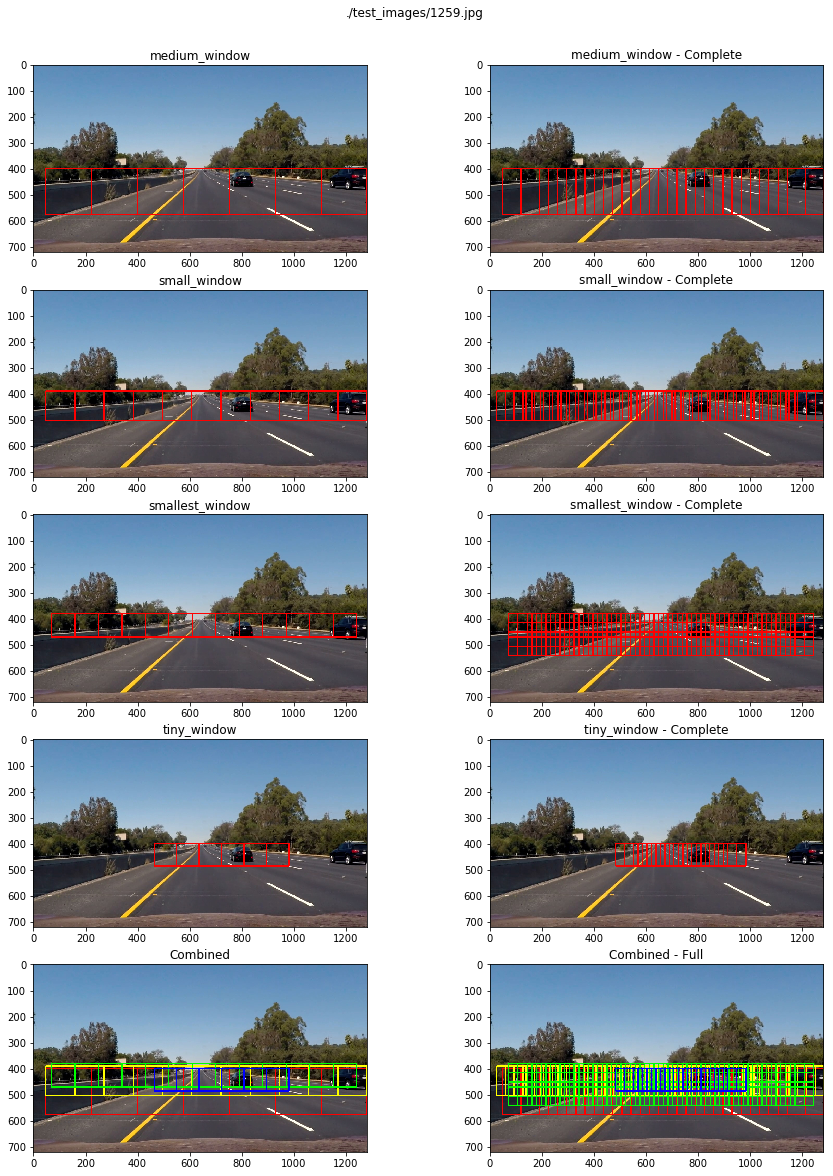

In [3]:
from windows import *

img_cs = load_image('./test_images/1259.jpg', params['color_space'])

total_medium = len(medium_window(img_cs))
total_small = len(small_window(img_cs))
total_smallest = len(smallest_window(img_cs))
total_tiny = len(tiny_window(img_cs))

print('Total Medium Windows:', total_medium)
print('Total Small Windows:', total_small)
print('Total Smallest Windows:', total_smallest)
print('Total Tiny Windows:', total_tiny)
print('Total Windows:', total_medium + total_small + total_smallest + total_tiny)

def draw_window_of_type(img, windowes, ax, title, color = (255, 0, 0)):
    img = np.copy(img)
    for window in windowes:
        cv2.rectangle(img, window[0], window[1], color, 4)
    ax.set_title(title)
    ax.imshow(img)
    return img

def draw_window_ax(img, windowes_combined, ax, title):
    img = np.copy(img)
    for windowes, color in windowes_combined:
        for window in windowes:
            cv2.rectangle(img, window[0], window[1], color, 4)
    ax.set_title(title)
    ax.imshow(img)
    return img

def show_window_sizes(filename, loaders):
    test_image = load_image(filename, 'RGB')
    
    f, ax = plt.subplots(len(loaders) + 1, 2, figsize=(15,20))
    f.suptitle(filename, y = 0.92)

    colors = [(255, 0, 0), (255, 255, 0), (0,255,0), (0,0,255), (0,255,255)]
    single_windowes = []
    full_windowes = []
    
    for i, loader in enumerate(loaders):
        windowes = loader(test_image, offset = (-1,0))
        single_windowes.append((windowes, colors[i]))
        
        draw_window_of_type(test_image, windowes, ax[i,0], str(loader).split(' ')[1])

        windowes = loader(test_image)
        full_windowes.append((windowes, colors[i]))
        
        draw_window_of_type(test_image, windowes, ax[i,1], str(loader).split(' ')[1] + ' - Complete')

    single_window_img = draw_window_ax(test_image, single_windowes, ax[len(loaders), 0], 'Combined')
    test_image = draw_window_ax(test_image, full_windowes, ax[len(loaders), 1], 'Combined - Full')
    
test_images = ['./test_images/1259.jpg']

for filename in test_images:
    show_window_sizes(filename, [medium_window, small_window, smallest_window, tiny_window])

plt.show()
plt.close('all')

## Different Types of Windows & Cars Detected

C:\Users\fahad\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


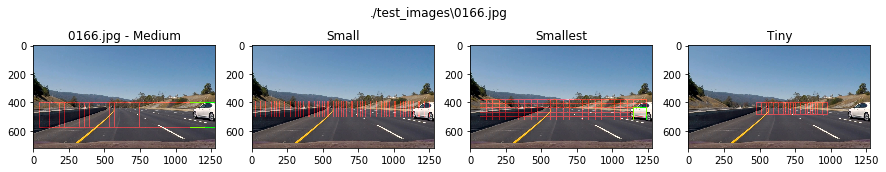

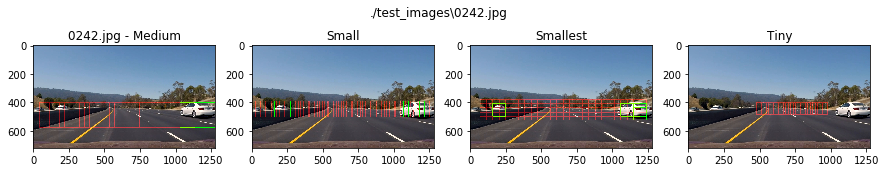

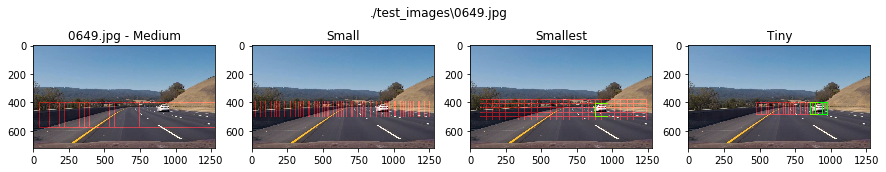

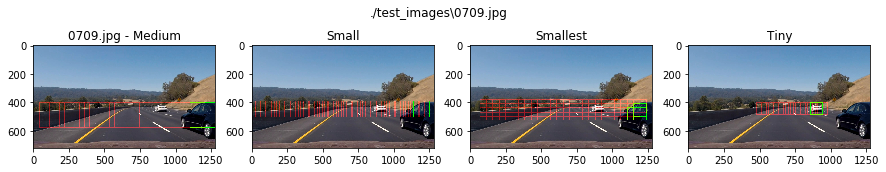

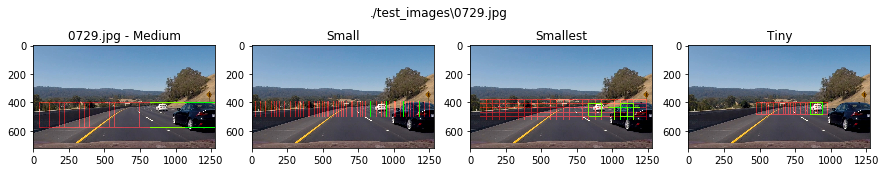

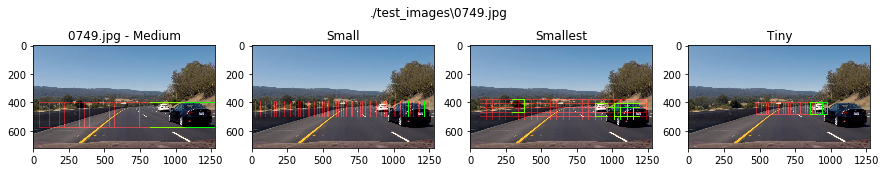

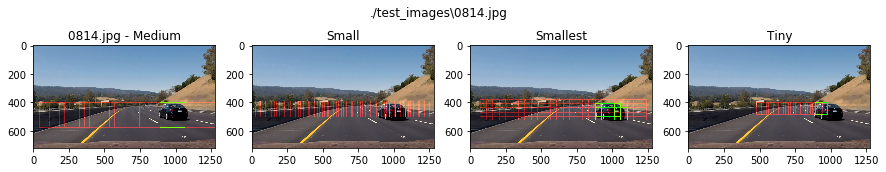

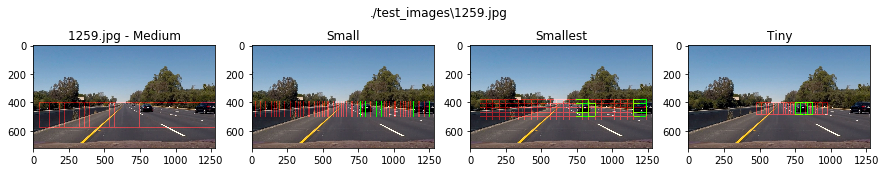

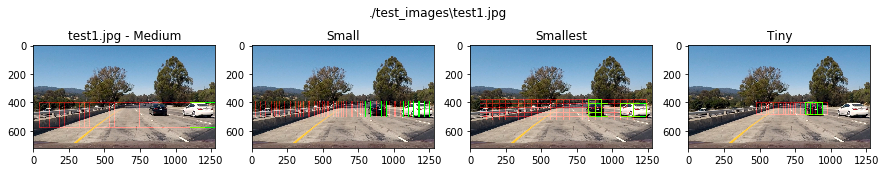

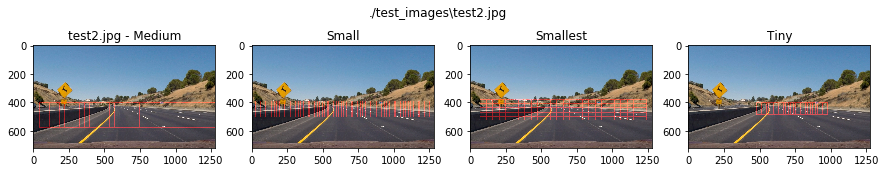

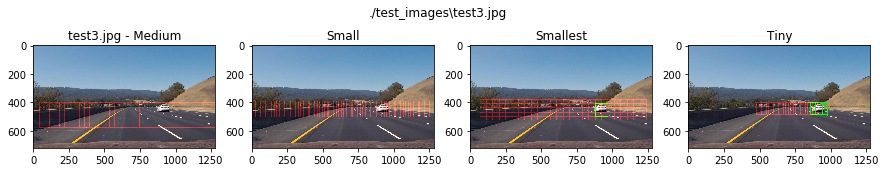

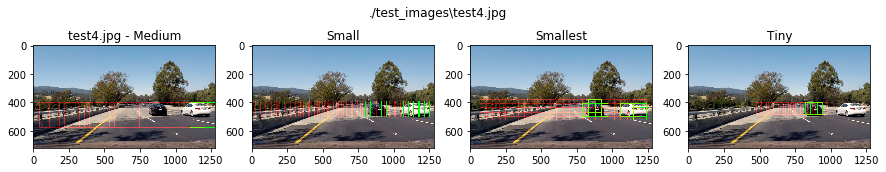

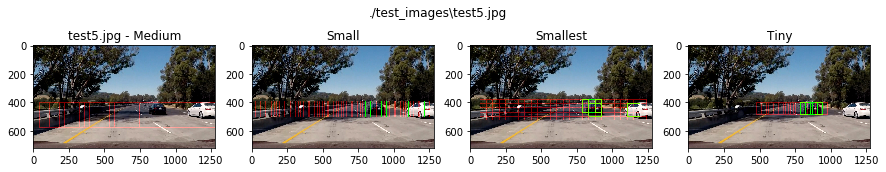

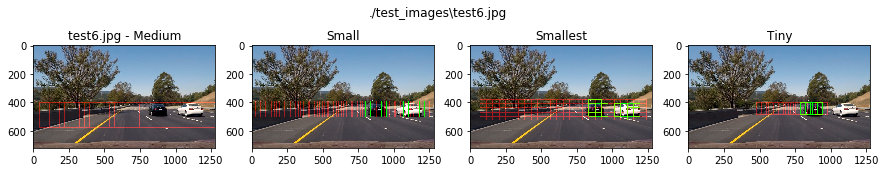

In [4]:
import os

def show_different_boxes(row_no, filename, ax):
    img = load_image(filename, 'RGB')
    basename = os.path.basename(filename)

    # in case we are using one big ouptut image for README.md then use ax[row,no,0] otherwise ax[0]
    
    if len(ax.shape) > 1:
        show_boxes_with_car(img, medium_window(img), '{} - Medium'.format(basename), ax[row_no,0])
        show_boxes_with_car(img, small_window(img), 'Small', ax[row_no,1])
        show_boxes_with_car(img, smallest_window(img, offset=(-0.5,0.3)), 'Smallest', ax[row_no,2])
        show_boxes_with_car(img, tiny_window(img), 'Tiny', ax[row_no,3])
    else:
        show_boxes_with_car(img, medium_window(img), '{} - Medium'.format(basename), ax[0])
        show_boxes_with_car(img, small_window(img), 'Small', ax[1])
        show_boxes_with_car(img, smallest_window(img, offset=(-0.5,0.3)), 'Smallest', ax[2])
        show_boxes_with_car(img, tiny_window(img), 'Tiny', ax[3])

def show_boxes_with_car(img, boxes, title, ax):
    img_cs = cv2.cvtColor(img, color_space_code)
    canvas = np.copy(img)
    canvas2 = np.zeros_like(img)
    
    for box in boxes:
        if has_car(img_cs, box):
            cv2.rectangle(canvas, box[0], box[1], (0,255,0), 4)
        else:
            cv2.rectangle(canvas2, box[0], box[1], (255,0,0), 4)

    canvas = cv2.addWeighted(canvas, 1, canvas2, 0.5, 0)
    ax.imshow(canvas)
    ax.set_title(title)

show_big_window = False
test_images = glob.glob('./test_images/*.jpg')

if show_big_window:
    f, ax = plt.subplots(len(test_images), 4, figsize=(15,40))
    f.tight_layout()

    for row_no, filename in enumerate(test_images):
        f, ax = plt.subplots(1, 4, figsize=(15,3))
        f.suptitle(filename, y = 0.92)
        show_different_boxes(row_no, filename, ax)
else:
    for row_no, filename in enumerate(test_images):
        f, ax = plt.subplots(1, 4, figsize=(15,3))
        f.suptitle(filename, y = 0.92)
        show_different_boxes(row_no, filename, ax)
        plt.show()

plt.show()
plt.close('all')

# Heatmap

In [5]:
import glob
from scipy.ndimage.measurements import label

def detect_cars(img, all_boxes = False):
    img_cs = cv2.cvtColor(img, color_space_code)
    
    boxes = get_all_windows(img_cs)
    car_boxes = []
    notcar_boxes = []
    
    for box in boxes:
        if has_car(img_cs, box):
            car_boxes.append(box)
        else:
            notcar_boxes.append(box)
            
    if not all_boxes:
        return car_boxes
    else:
        return car_boxes, notcar_boxes

def heatmap_threshold(heatmap, threshold):
    heatmap[heatmap < threshold] =  0
    
def add_heat(heatmap, windows):
    for window in windows:
        heatmap[window[0][1]:window[1][1], window[0][0]:window[1][0]] += 1
    
def draw_labeled_bboxes(img, labels):
    colors = [(255,0,0), (0,255,0), (0, 0, 255), (255, 255, 0), (0, 255, 255),
              (255, 0, 255), (255, 150, 0), (255, 0, 150), (150, 75, 0), (150, 0, 75)]

    labels_img = np.zeros_like(img)
    
    # add more colors to the array in case there are more labels than number of defined colors
    if labels[1] == len(colors):
        extra = labels[1] - len(colors)
        colors.extend([(255,0,0)] * extra)
    
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        mask = labels[0] == car_number
        labels_img[mask] = colors[car_number - 1]
        
        nonzero = (mask).nonzero()
        
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))

        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    return labels_img

def get_heat_img(heatmap, img, weight = (0.4,0.6)):
    hot_colors = [(90,0,0), (212,0,0), (255, 63, 0), (255,103,0), (255,225,0), (255,225,0), (255,225,0)]

    heatmap_clipped = np.clip(heatmap, 0, 255)
    max_heat = np.max(heatmap_clipped)
    cap = len(hot_colors)
    if max_heat >= cap:
        heatmap_clipped = (heatmap_clipped / max_heat) * cap

    heat_img = np.zeros(shape=img.shape).astype(np.uint8)
    print(heat_img.shape)
    for index, color in enumerate(hot_colors):
        heat_img[heatmap_clipped > index] = color

    return cv2.addWeighted(img, weight[0], heat_img, weight[1], 0)

def draw_car_notcar(img, car_boxes, boxes):
    for box in notcar_boxes:
        cv2.rectangle(img, box[0], box[1], (255,0,0), 4)
    for box in car_boxes:
        cv2.rectangle(img, box[0], box[1], (0,255,0), 6)

## Heatmap Image Test Using Static Window

3.0
6.0
9.0
(720, 1280, 3)


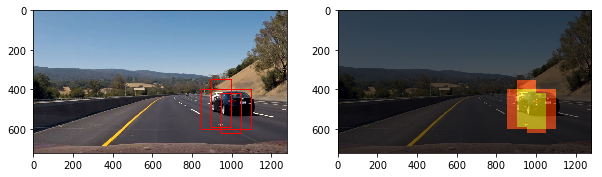

In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

windows = [((850,400), (1100, 600)), ((900,350), (1000,590)), ((950,420),(1050,620))]

img = cv2.imread('./project_video-frames/0800.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
heatmap = np.zeros(shape=img.shape[:2])

add_heat(heatmap, windows)
print(np.max(heatmap))
add_heat(heatmap, windows)
print(np.max(heatmap))
add_heat(heatmap, windows)
print(np.max(heatmap))
add_heat(heatmap, windows)

heat_img = get_heat_img(heatmap, img)

for w in windows:
    cv2.rectangle(img, w[0], w[1], (255,0,0), 4)

f, (ax1, ax2) = plt.subplots(1,2,figsize=(10,5))

ax1.imshow(img)
ax2.imshow(heat_img)

plt.show()

## Heatmap Image Test Using Has_Car and SVM

Testing on 1 files


C:\Users\fahad\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


(720, 1280, 3)


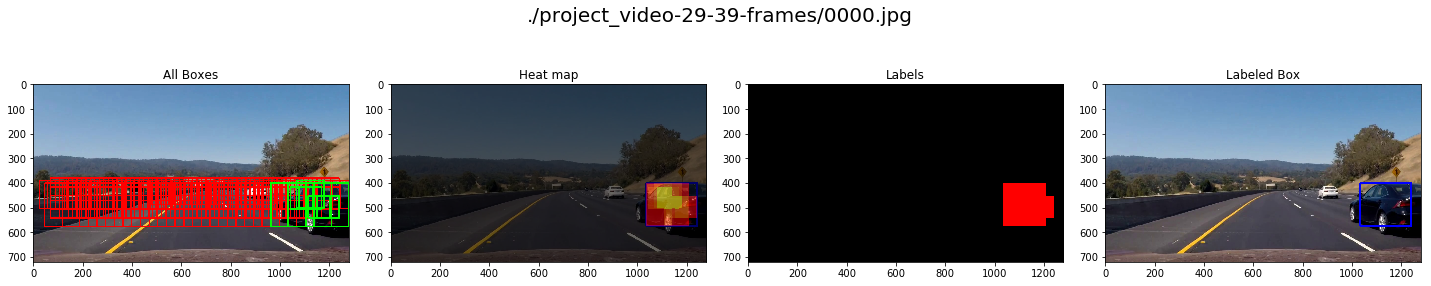

In [7]:
#test_images = glob.glob('./test_images/*.jpg')
test_images = ['./project_video-29-39-frames/0000.jpg']
print('Testing on {} files'.format(len(test_images)))

for filename in test_images:
    img = load_image(filename, 'RGB')

    heatmap = np.zeros(img.shape[:2], np.float32)
    
    car_boxes, notcar_boxes = detect_cars(img, True)
    #print(car_boxes)
    
    img_boxes = np.copy(img)
    draw_car_notcar(img_boxes, car_boxes, notcar_boxes)
    
    add_heat(heatmap, car_boxes)
    heatmap_threshold(heatmap, 2)
    labels = label(heatmap)
    labels_img = draw_labeled_bboxes(img, labels)

    heat_img = get_heat_img(heatmap, img)
    
    f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4,figsize=(20,5))
    f.tight_layout()
    f.suptitle(filename, fontsize=20)
    ax1.imshow(img_boxes)
    ax1.set_title('All Boxes')
    ax2.imshow(heat_img)
    ax2.set_title('Heat map')
    ax3.imshow(labels_img)
    ax3.set_title('Labels')
    ax4.imshow(img)
    ax4.set_title('Labeled Box')
    
plt.show()
plt.close('all')


## Testing Windows Having Cars / Fast Positive Zoom

C:\Users\fahad\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


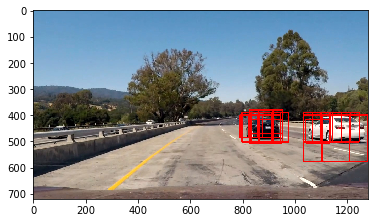

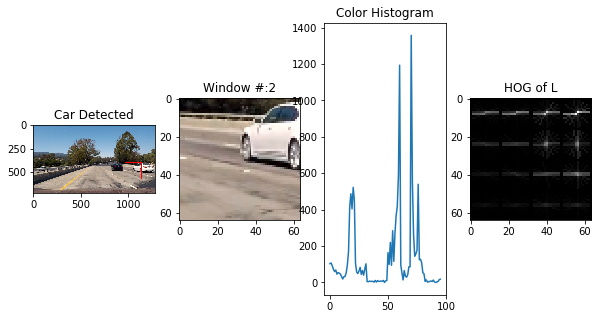

In [9]:
import os
import threading
import time

class Problemwindow:
    def __init__(self, filename, loader = smallest_window):
        self.filename = filename
        self.img = load_image(filename, 'RGB')
        self.img_cs = cv2.cvtColor(self.img, color_space_code)
        self.windowes = loader(self.img)
        
    def show_specific_window(self, window_no, color=(255,0,0)):
        img_copy = np.copy(self.img)

        window = self.windowes[window_no]
        cv2.rectangle(img_copy, window[0], window[1], color, 4)

        window_img = get_window_pixels(self.img, window)
        window_img_cs = get_window_pixels(self.img_cs, window)
        color_features = color_hist(window_img_cs)
        
        _, hog_img_l = get_hog_features(window_img_cs[:,:,0], 
                                orient = params['orient'], 
                                pix_per_cell = params['pix_per_cell'], 
                                cell_per_block = params['cell_per_block'], 
                                vis=True, 
                                feature_vec=True)
        
        f, (ax1, ax2, ax3, ax4) = plt.subplots(1,4,figsize=(10,5))
        ax1.imshow(img_copy)
        ax1.set_title('Car Detected')
        ax2.imshow(window_img)
        ax2.set_title('Window #:{}'.format(window_no))
        ax3.plot(color_features)
        ax3.set_title('Color Histogram')
        ax4.imshow(hog_img_l, cmap='gray')
        ax4.set_title("HOG of L")
        
        return window_img
            

    def get_window_filename(self, window_no):
        basename = os.path.basename(self.filename)
        file_no_ext = os.path.splitext(basename)[0]
        return './problem/{}-{}.jpg'.format(file_no_ext, window_no)

    def save_window(self, window_no):
        output = self.get_window_filename(window_no)
        window = self.windowes[window_no]
        window_img = get_window_pixels(self.img, window)
        window_img_bgr = cv2.cvtColor(window_img, cv2.COLOR_RGB2BGR)
        cv2.imwrite(output, window_img_bgr)
        print(output)

    def show_window_nos(self, window_nos):
        for window_no in window_nos:
            self.show_specific_window(window_no)

    def show_all_cars(self, img, close_up = False, save = False):
        for window_no, window in enumerate(self.windowes):
            if has_car(self.img_cs, window):
                cv2.rectangle(img, window[0], window[1], (255, 0, 0), 4)
                #print('Found car at window', window, window_no)
                
                if close_up:
                    self.show_specific_window(window_no, color=(0,255,0))

                if save:
                    self.save_window(window_no)

test_images = glob.glob('./project_video-frames/0999.jpg')

for filename in test_images:
    pb = Problemwindow(filename, get_all_windows)
    img = np.copy(pb.img)
    
    t1 = time.time()
    pb.show_all_cars(img, save = False)
    t2 = time.time()

    plt.imshow(img)
    plt.show()

filename = './project_video-frames/0999.jpg'
pb = Problemwindow(filename, medium_window)
pb.show_window_nos([2])

plt.show()
plt.close('all')